# OCR Model for Reading CAPTCHAs

Based on: https://keras.io/examples/vision/captcha_ocr/

## Introduction

A simple OCR model built with the Functional API. It combines CNN and RNN, and illustrates how you can instantiate a new layer and use it as an "Endpoint layer" for implementing CTC loss.

## Setup

In [11]:
import os
from collections import Counter
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the Data: CAPTCHA Images

Besides loading the CAPTCHA images, I found it to be more accurate if I split the images into their individual letters.

In [12]:
# Split images into 4 columns.
captcha_images = Path("./captcha_images_v2/")

for image_path in captcha_images.iterdir():
    image = cv2.imread(str(image_path))
    label = image_path.name.split(".png")[0]

    for i in range(5):
        image_col = image[:, i * 40:(i + 1) * 40]
        cv2.imwrite(f"./captcha_letters/{label[i]}_{label}.png", image_col)

In [13]:
# Path to data directory.
data_dir = Path("./captcha_letters/")

# Get list of all the image paths.
images = sorted([str(image_path) for image_path in data_dir.glob("*.png")])
labels = [image.split(os.path.sep)[-1].split(".png")[0][0] for image in images]
characters = sorted(list(set(labels)))

print(f"Number of images found: {len(images)}")
print(f"Number of labels  found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

# Batch size for training and validation.
batch_size = 16

# Desired image dimensions.
img_width = 40
img_height = 80

# Factor by which the image is going to be downsampled by the convolution
# blocks. We will be using two convolution blocks and each block will have
# a pooling layer which downsamples the features by a factor of 2. Hence,
# the total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset.
max_length = 1

Number of images found: 2022
Number of labels  found: 2022
Number of unique characters: 33
Characters present: ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'N', 'Q', 'R', 'T', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'n', 'q', 'r', 't']


## Preprocessing

In [14]:
# Mapping characters to integers.
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


def split_data(images: list[str], labels: list[str], train_size=0.9, shuffle=True):
    """
    Split the dataset into train/validation sets.

    Args:
        images (list[str]): List of paths to the CAPTCHA images.
        labels (list[str]): List of labels for each CAPTCHA image.
        train_size (float, optional): Ratio of train data. Defaults to 0.9.
        shuffle (bool, optional): Whether to shuffle the dataset. Defaults to True.
    """

    # Get the size and respective indices of the entire dataset.
    size = len(images)
    indices = np.arange(size)

    if shuffle:
        np.random.shuffle(indices)

    # Get the size of the training samples.
    train_samples = int(size * train_size)

    # Split the data into train/validation sets.
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path: str, label: str):
    """
    Performs preprocessing on a single image-pair in the OCR dataset.

    Args:
        img_path (str): Path to image.
        label (str): Label of image.
    """

    # Returns a tensor of the image specified.
    img = tf.io.read_file(img_path)

    # Decode and convert to grayscale, i.e. representing pixel values as unsigned 8-bit
    # integers.
    img = tf.io.decode_png(img, channels=1)

    # Convert the pixels of the image to float32 datatype and scale the values betwween
    # the 0 and 1 range.
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize to the desired size.
    img = tf.image.resize(img, [img_height, img_width])

    # Transponse the image because we want the time dimension to correspond to the width
    # of the image.
    # (height, width, channels) -> (width, height, channels)
    img = tf.transpose(img, perm=[1, 0, 2])

    # Map the characters in labels to numbers.
    # tf.strings.unicode_split: splits the label string into individual Unicode characters.
    # char_to_num : outputs a tensor where each character is represented by an integer value.
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

## Create `Dataset` Objects

In [15]:
# Creates a dataset from tensors x_train and y_train.
# Each element of the dataset will be a tuple (x_train[i], y_train[i])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# First, apply encode_single_sample() on each instance of the dataset.
# num_parallel_calls=tf.data.AUTOTUNE determines the optimal amount of parallelism to use
# when mapping the function to each instance of the dataset.
# Afterwards, .batch() groups the dataset into batches.
# Finally, .prefetch() defines a buffer in memory that can hold a certain number of elements.
# By prefetching, TensorFlow can get ready and process one batch of data, while another is
# being trained, thereby saving time.
train_dataset = (train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Do the same thing for the validation dataset.
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the Data

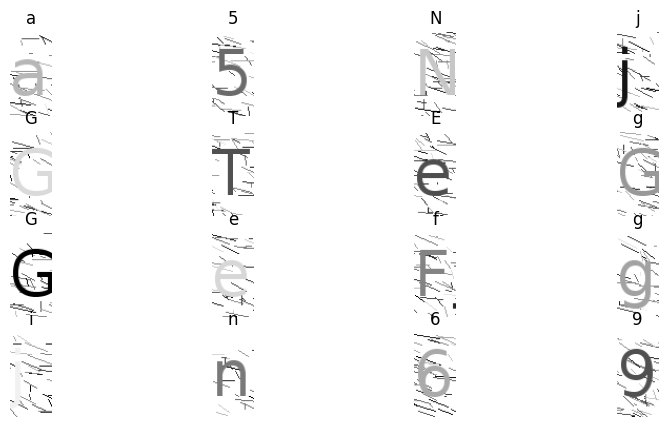

In [16]:
# Creates a figure and set of subplots.
_, ax = plt.subplots(4, 4, figsize=(10, 5))

# Take 1 batch from the train_dataset.
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        # Multiplies each pixel by 255, converts the TensorFlow tensor to a NumPy array, and
        # converts the pixels to uint8 data.
        img = (images[i] * 255).numpy().astype("uint8")

        # num_to_char() maps the numerical value back to its original character.
        # tf.strings.reduce_join() joins the characters into a single string.
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

        # ax[i // 4, i % 4] selects the subplot position.
        # imshow() displays the image on the specified subplot.
        # img[:, :, 0] selects all rows and columns of the image selects the first channel
        # along the third dimension.
        # .T transposes the image array into the proper arrangement so it can be displayed.
        # cmap="gray" displays the images in grayscale.
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

## Model

In [17]:
# A layer is a callable object that takes as input one or more tensors that outputs
# one or more tensors.
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        # Calculate the number of samples in the batch.
        # tf.shape(y_true)[0] : extracts the first element of the shape of the y_true tensor
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First convolution block.
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1"
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second convolution block.
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2. Hence, downsampled feature
    # maps are 4x smaller. The number of filters in the last layer is 64. Reshape
    # accordingly before passing the output to the RNN part of the model.
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer.
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")

    # Optimizer.
    opt = keras.optimizers.Adam()

    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 40, 80, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 40, 80, 32)           320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 20, 40, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 20, 40, 64)           18496     ['pool1[0][0]']               
                                                                                       

## Training

In [18]:
epochs = 100
early_stopping_patience = 10

# Add early stopping.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# Train the model.
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
114/114 [==============================] - 7s 33ms/step - loss: 5.2575 - val_loss: 4.3366
Epoch 2/100
114/114 [==============================] - 2s 19ms/step - loss: 3.9545 - val_loss: 3.5417
Epoch 3/100
114/114 [==============================] - 2s 20ms/step - loss: 3.5413 - val_loss: 3.4936
Epoch 4/100
114/114 [==============================] - 2s 19ms/step - loss: 3.5038 - val_loss: 3.4853
Epoch 5/100
114/114 [==============================] - 2s 19ms/step - loss: 3.4929 - val_loss: 3.4920
Epoch 6/100
114/114 [==============================] - 2s 19ms/step - loss: 3.4881 - val_loss: 3.4819
Epoch 7/100
114/114 [==============================] - 2s 19ms/step - loss: 3.4868 - val_loss: 3.4798
Epoch 8/100
114/114 [==============================] - 2s 19ms/step - loss: 3.4823 - val_loss: 3.4773
Epoch 9/100
114/114 [==============================] - 2s 19ms/step - loss: 3.4811 - val_loss: 3.4754
Epoch 10/100
114/114 [==============================] - 2s 19ms/step - loss: 3.477

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 40, 80, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 40, 80, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 20, 40, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 20, 40, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 10, 20, 64)        0         
                                                                 
 reshape (Reshape)           (None, 10, 1280)          0         
                                                                 
 dense1 (Dense)              (None, 10, 64)            8198

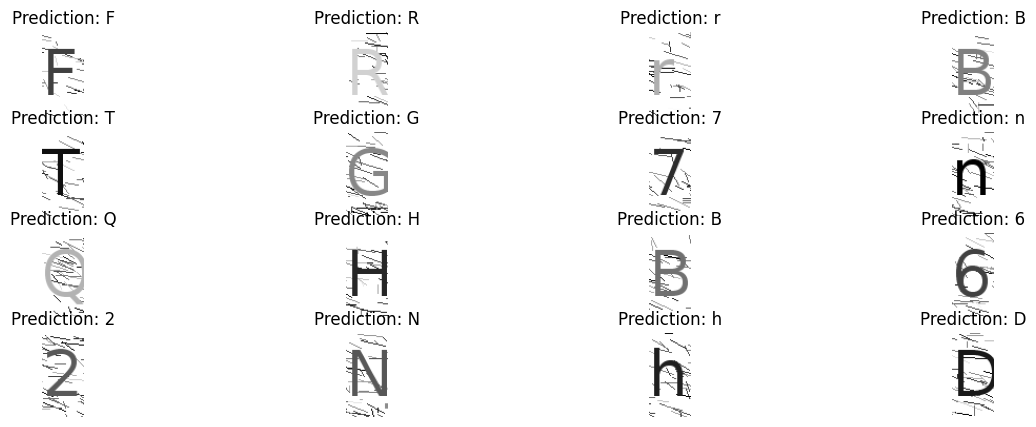

In [19]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [20]:
# prediction_model.save("./model/")
# prediction_model.save("C:/Users/wuihee/Desktop/Programming/Projects/BBDC Sniping Bot/bbdc-sniping-bot/captcha_prediction_model")